In [33]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df = pd.read_csv("dataset.csv")
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format="%d-%m-%Y %H:%M:%S")

In [35]:
# Sort by parking space and time
df = df.sort_values(by=['SystemCodeNumber', 'timestamp']).reset_index(drop=True)

In [36]:

df['price'] = np.nan

BasePrice = 10.0
alpha = 2.0  

In [37]:
#Convert
df['Occupancy'] = pd.to_numeric(df['Occupancy'], errors='coerce')
df['Capacity'] = pd.to_numeric(df['Capacity'], errors='coerce')
df['QueueLength'] = pd.to_numeric(df['QueueLength'], errors='coerce')
df['IsSpecialDay'] = pd.to_numeric(df['IsSpecialDay'], errors='coerce')

In [38]:

traffic_map = {"low": 0.0, "average": 0.5, "high": 1.0}
df['TrafficScore'] = df['TrafficConditionNearby'].map(traffic_map)

In [39]:

vehicle_weights = {"bike": 0.5, "car": 1.0, "truck": 2.0}
df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights)

In [40]:

weights = {
    'Occupancy': 0.4,
    'QueueLength': 0.2,
    'TrafficScore': 0.2,
    'SpecialDay': 0.1,
    'VehicleWeight': 0.1
}
# Store rerouting
reroute_suggestions = []

In [41]:

for code, group in df.groupby('SystemCodeNumber'):
    group = group.sort_values('timestamp')
    prices = [BasePrice]

    for i in range(1, len(group)):
        prev_price = prices[-1]
        row = group.iloc[i - 1]

        if row['Capacity'] > 0:
            occ_ratio = row['Occupancy'] / row['Capacity']
        else:
            occ_ratio = 0

        # Calculate price increment
        delta = alpha * (
            weights['Occupancy'] * occ_ratio +
            weights['QueueLength'] * row['QueueLength'] +
            weights['TrafficScore'] * row['TrafficScore'] +
            weights['SpecialDay'] * row['IsSpecialDay'] +
            weights['VehicleWeight'] * row['VehicleWeight']
        )

        new_price = min(prev_price + delta, 30.0)
        prices.append(new_price)

        # Rerouting condition
        if occ_ratio > 0.9 or row['QueueLength'] > 5:
            reroute_suggestions.append({
                'timestamp': row['timestamp'],
                'FromLot': code,
                'Latitude': row['Latitude'],
                'Longitude': row['Longitude'],
                'Reason': 'Overload'
            })

    df.loc[group.index, 'price'] = prices


In [42]:
df.to_csv("DynamicPriceModel.csv", index=False)

pd.DataFrame(reroute_suggestions).to_csv("ReroutingSuggestions.csv", index=False)


#  SAMPLE PLOT

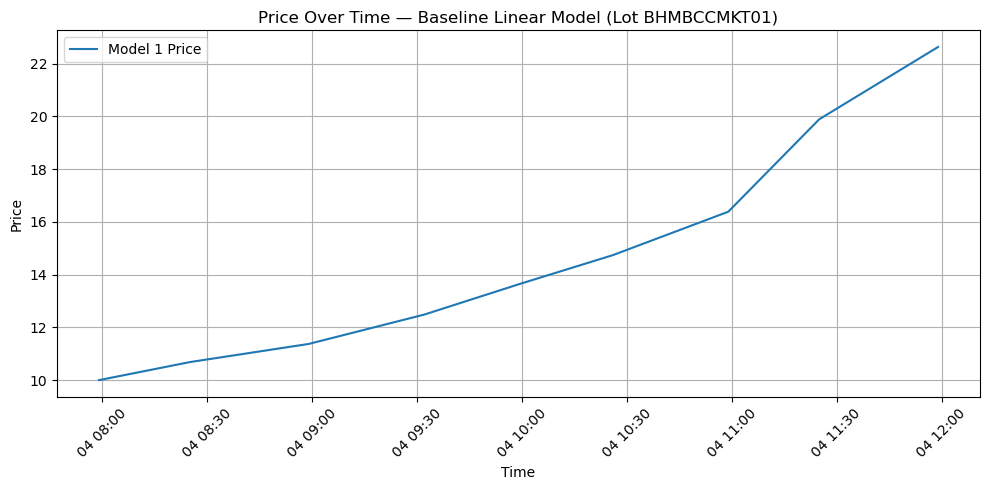

In [56]:
df = pd.read_csv("DynamicPriceModel.csv", parse_dates=['timestamp'])

lot_id = df['SystemCodeNumber'].unique()[0]
df_lot = df[df['SystemCodeNumber'] == lot_id]

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_lot, x='timestamp', y='price', label='Model 1 Price')
plt.title(f'Price Over Time — Baseline Linear Model (Lot {lot_id})')
plt.xlabel('Time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### DEMAND PREDICTION 

In [47]:
BasePrice = 10.0
k = 0.3  # elasticity
Lambda = 0.7

Alpha = 0.4
Beta = 0.2
Gamma = 0.3
Delta = 0.1
Epsilon = 0.1

In [48]:
df['RawDemand'] = (
    Alpha * (df['Occupancy'] / df['Capacity'].replace(0, np.nan)) +
    Beta * df['QueueLength'] -
    Gamma * df['TrafficScore'] +
    Delta * df['IsSpecialDay'] +
    Epsilon * df['VehicleWeight']
)

# Normalize demand
def normalize(series):
    return (series - series.mean()) / (series.std() + 1e-6)

df['NormalizedDemand'] = df.groupby('SystemCodeNumber')['RawDemand'].transform(normalize)

#### Model-1 Linear 

In [49]:
df['Price1'] = BasePrice * (1 + Lambda * df['NormalizedDemand'])

df['Price1'] = df['Price1'].clip(lower=0.5 * BasePrice, upper=2 * BasePrice)

# Save
df.to_csv("DemandModelOutput.csv", index=False)


#### Model-2 Exponential

In [50]:
# Exponential pricing
df['Price2'] = BasePrice * np.exp(k * df['NormalizedDemand'])

# Smooth bounding
df['Price2'] = df['Price2'].clip(lower=0.5 * BasePrice, upper=2.0 * BasePrice)

df.to_csv("ExponentialElasticPriceModel.csv", index=False)

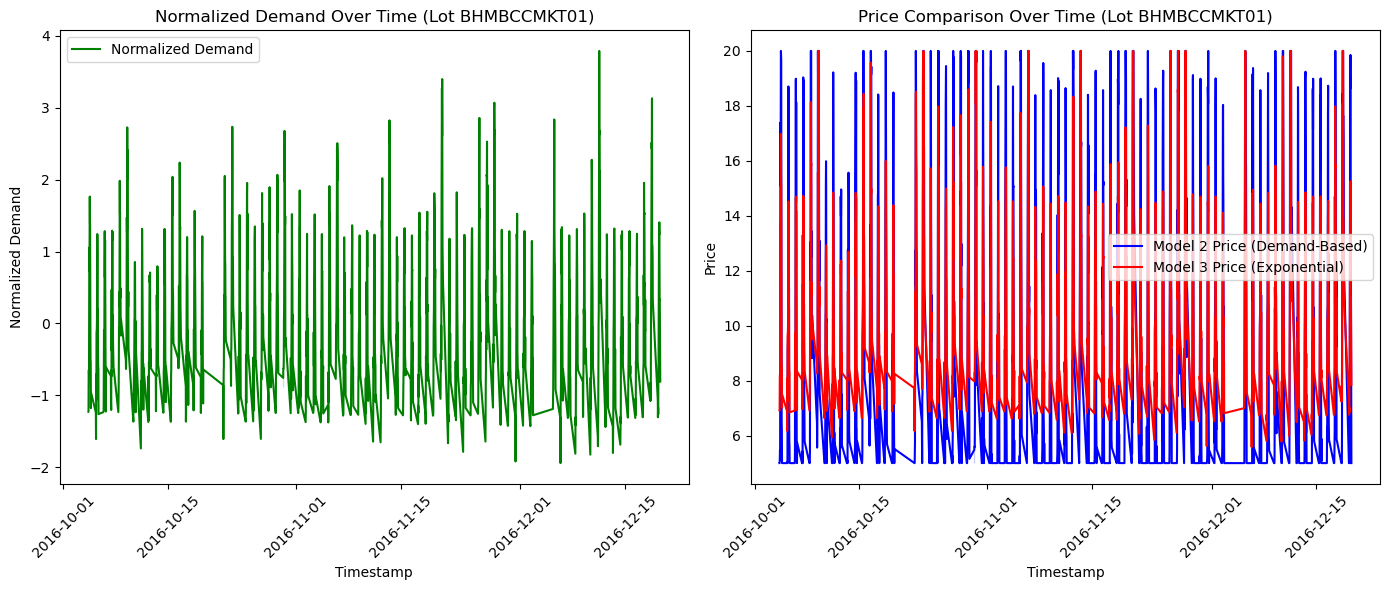

In [53]:
df_exp = pd.read_csv("ExponentialElasticPriceModel.csv", parse_dates=['timestamp'])
df_demand = pd.read_csv("DemandModelOutput.csv", parse_dates=['timestamp'])

merged = pd.merge(
    df_exp[['timestamp', 'SystemCodeNumber', 'Price2', 'NormalizedDemand']],
    df_demand[['timestamp', 'SystemCodeNumber', 'Price1']],
    on=['timestamp', 'SystemCodeNumber'],
    suffixes=('_Exp', '_Demand')
)

# Pick a lot to visualize
sample_lot = merged['SystemCodeNumber'].unique()[0]
sample_data = merged[merged['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(14, 6))

# Demand plot
plt.subplot(1, 2, 1)
sns.lineplot(data=sample_data, x='timestamp', y='NormalizedDemand', label='Normalized Demand', color='green')
plt.title(f'Normalized Demand Over Time (Lot {sample_lot})')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Demand')
plt.xticks(rotation=45)

# Price comparison plot
plt.subplot(1, 2, 2)
sns.lineplot(data=sample_data, x='timestamp', y='Price1', label='Model 2 Price (Demand-Based)', color='blue')
sns.lineplot(data=sample_data, x='timestamp', y='Price2', label='Model 3 Price (Exponential)', color='red')
plt.title(f'Price Comparison Over Time (Lot {sample_lot})')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


#### Plot using Bokeh

In [65]:
!pip install bokeh geopy panel

In [66]:
from bokeh.plotting import figure, curdoc
from bokeh.models import ColumnDataSource, Select
from bokeh.layouts import column
from geopy.distance import geodesic
import panel as pn
pn.extension()

In [78]:
def get_nearby_lots(main_lot, radius_km=0.5):
    main_coords = tuple(location_map.loc[main_lot])
    nearby = []
    for lot, coords in location_map.iterrows():
        if lot != main_lot:
            dist = geodesic(main_coords, (coords['Latitude'], coords['Longitude'])).km
            if dist <= radius_km:
                nearby.append(lot)
    return nearby

def update_plot(attr, old, new):
    main_lot = select.value
    nearby = get_nearby_lots(main_lot)

    main_data = df[df['SystemCodeNumber'] == main_lot].copy()
    main_data['Label'] = f"Lot {main_lot}"

    for comp in nearby:
        comp_data = df[df['SystemCodeNumber'] == comp].copy()
        comp_data['Label'] = f"Lot {comp}"
        main_data = pd.concat([main_data, comp_data])

    if not main_data.empty:
        main_data = main_data.sort_values('timestamp')
        source.data = {
            'Timestamp': main_data['timestamp'],
            'Price': main_data['Price2'],
            'Label': main_data['Label']
        }
        p.title.text = f"Pricing Behavior: Lot {main_lot} vs {len(nearby)} Competitor(s)"
    else:
        source.data = dict(Timestamp=[], Price=[], Label=[])
        p.title.text = f"No data for Lot {main_lot}"


In [73]:
# Load your model output file (adjust path if needed)
df = pd.read_csv("ExponentialElasticPriceModel.csv", parse_dates=["timestamp"])

# Ensure all required columns exist
required_columns = ['SystemCodeNumber', 'timestamp', 'Latitude', 'Longitude', 'Price2']
missing = [col for col in required_columns if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Setup unique parking lots
lots = sorted(df['SystemCodeNumber'].dropna().unique())
location_map = df.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first()

# ColumnDataSource to store plot data
source = ColumnDataSource(data=dict(Timestamp=[], Price=[], Label=[]))


In [80]:
# Bokeh figure setup
p = figure(x_axis_type="datetime", height=400, title="Pricing Behavior", tools="pan,wheel_zoom,reset")
p.line(x='timestamp', y='Price2', source=source, line_width=2, color='navy', legend_field='Label')
p.legend.location = "top_left"

# Dropdown menu
select = Select(title="Select Parking Lot", value=lots[0], options=lots)


In [81]:
# Attach callback (correct Bokeh way)
select.on_change('value', update_plot)

# Trigger once to load initial data
update_plot(None, None, None)

# Show inline with Panel
pn.Column(select, p)


Column
    [0] Bokeh(Select)
    [1] Bokeh(figure)

In [69]:
# Load dataset
df = pd.read_csv("ExponentialElasticPriceModel.csv", parse_dates=['timestamp'])

# Get list of lots
lots = sorted(df['SystemCodeNumber'].unique().tolist())
location_map = df.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first()

# Source for Bokeh
source = ColumnDataSource(data=dict(Timestamp=[], Price=[], Label=[]))

# Plot
p = figure(x_axis_type='datetime', height=400, title="Pricing Behavior", tools="pan,wheel_zoom,reset")
p.line(x='timestamp', y='Price2', source=source, line_width=2, legend_field='Label')
p.legend.location = "top_left"

# Dropdown widget
select = Select(title="Select Parking Lot", value=lots[0], options=lots)

# Proximity-based competitor selection
def get_nearby_lots(main_lot):
    main_coords = tuple(location_map.loc[main_lot])
    nearby = []
    for lot, row in location_map.iterrows():
        if lot != main_lot:
            dist = geodesic(main_coords, (row['Latitude'], row['Longitude'])).km
            if dist <= 0.5:
                nearby.append(lot)
    return nearby

# Update function
def update_plot(attr, old, new):
    main_lot = select.value
    nearby = get_nearby_lots(main_lot)

    main_data = df[df['SystemCodeNumber'] == main_lot].copy()
    main_data['Label'] = f"Lot {main_lot}"

    for comp in nearby:
        comp_data = df[df['SystemCodeNumber'] == comp].copy()
        comp_data['Label'] = f"Lot {comp}"
        main_data = pd.concat([main_data, comp_data])

    main_data.sort_values('timestamp', inplace=True)
    source.data = {
        'Timestamp': main_data['timestamp'],
        'Price': main_data['Price2'],
        'Label': main_data['Label']
    }
    p.title.text = f"Pricing Behavior: Lot {main_lot} vs Competitors"

# Initial update
update_plot(None, None, None)
select.on_change('value', update_plot)

# Display in notebook using Panel
pn.Column(select, p)


Column
    [0] Bokeh(Select)
    [1] Bokeh(figure)

In [68]:
pn.serve(pn.Column(select, p), show=True, port=5006)

Launching server at http://localhost:5006


In [60]:
# Load price data (e.g., Model 2 or Model 3 output)
df = pd.read_csv("ExponentialElasticPriceModel.csv", parse_dates=['timestamp'])

In [64]:
# Get unique lots
lots = df['SystemCodeNumber'].unique().tolist()
lots.sort()

# Store location data
location_map = df.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first()

# Base price source (will update based on selected lot)
source = ColumnDataSource(data=dict(Timestamp=[], Price=[], Label=[]))

# Set up figure
p = figure(x_axis_type='datetime', height=400, title="Price Trend", tools="pan,wheel_zoom,reset")
p.line(x='timestamp', y='Price2', source=source, line_width=2, legend_field='Label')
p.legend.location = "top_left"

# Dropdown to choose parking lot
select = Select(title="Select Parking Lot", value=str(lots[0]), options=[str(l) for l in lots])

# Find competitors within 500m
def get_nearby_lots(main_lot):
    main_coords = tuple(location_map.loc[main_lot])
    nearby = []
    for lot, row in location_map.iterrows():
        dist = geodesic(main_coords, (row['Latitude'], row['Longitude'])).km
        if lot != main_lot and dist <= 0.5:
            nearby.append(lot)
    return nearby

# Update data
def update_plot(attr, old, new):
    main_lot = select.value  # Keep as string
    nearby = get_nearby_lots(main_lot)

    # Get main lot prices
    main_data = df[df['SystemCodeNumber'] == main_lot].copy()
    main_data['Label'] = f"Lot {main_lot}"

    # Add competitors
    for comp in nearby:
        comp_data = df[df['SystemCodeNumber'] == comp].copy()
        comp_data['Label'] = f"Lot {comp}"
        main_data = pd.concat([main_data, comp_data])

    # Update plot source
    main_data.sort_values('timestamp', inplace=True)
    source.data = {
        'Timestamp': main_data['timestamp'],
        'Price': main_data['Price2'],
        'Label': main_data['Label']
    }
    p.title.text = f"Pricing Behavior: Lot {main_lot} vs Competitors"

# Trigger initial plot
update_plot(None, None, None)

# Attach event
select = Select(title="Select Parking Lot", value=lots[0], options=lots)

# Layout
layout = column(select, p)
curdoc().add_root(layout)
curdoc().title = "Urban Parking Pricing"